In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
sns.set()

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


In [3]:
df.shape

(937854, 3)

In [4]:
df.apply(pd.isnull).sum()

Text         0
Language    23
Label        0
dtype: int64

In [5]:
df.dropna(subset = ['Language'], inplace = True)

In [6]:
df.shape

(937831, 3)

In [7]:
df.isnull().sum()

Text        0
Language    0
Label       0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(4974)

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.shape

(932857, 3)

In [12]:
df['Language'].value_counts()

Language
en                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  867178
fr                                                                                                                                                                  

In [13]:
df = df[df['Language'] =='en']

In [14]:
df.shape

(867178, 3)

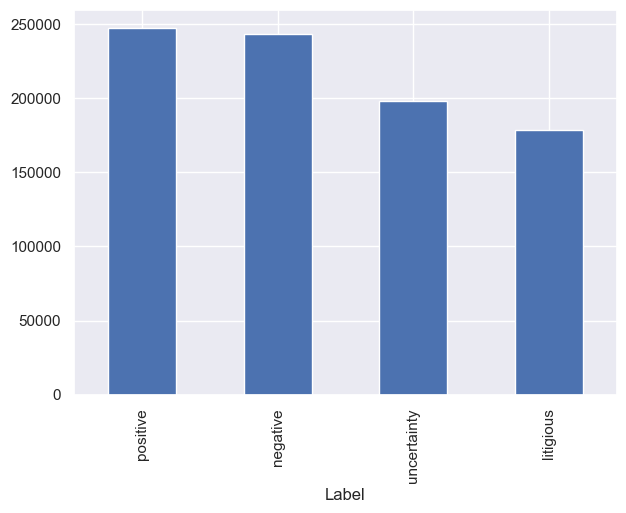

In [15]:
df['Label'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [16]:
df_po = df[df['Label'] == 'positive'].sample(150000)
df_ne = df[df['Label'] == 'negative'].sample(150000)

In [17]:
df_un = df[df['Label'] == 'uncertainty'].sample(30000)
df_li = df[df['Label'] == 'litigious'].sample(30000)

In [18]:
df_balanced = pd.concat([df_po, df_ne])

In [19]:
df_balanced.head()

,Text,Language,Label
183931,@Lion0fWar @JimBlack48 @tedcruz Anyway; the in...,en,positive
698185,Incredible face! So Gorgeous like a CG\n\nKARI...,en,positive
370923,harmony tan!!! incredible,en,positive
665355,@GaryCarr19 @King_Willi5 @overtime @_kayinlee ...,en,positive
69446,This New Kindle Unlimited Deal is Incredible: ...,en,positive


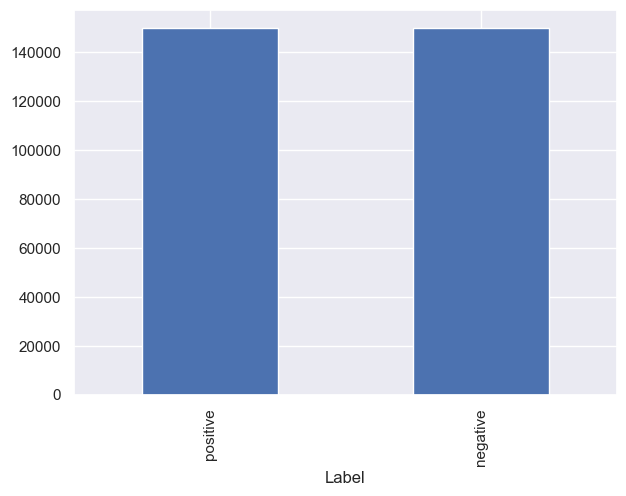

In [20]:
df_balanced['Label'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

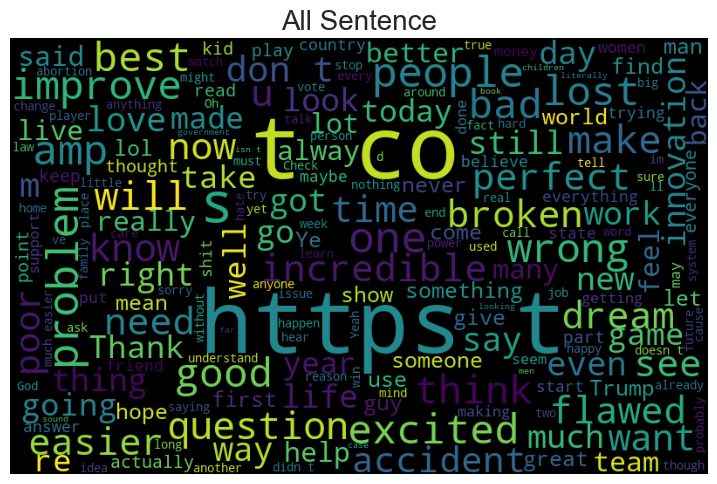

In [21]:
plt.figure(figsize = (9, 9))
all_sen = ' '.join([sentence for sentence in df_balanced['Text']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sen)
plt.imshow(word_cloud)
plt.title('All Sentence', fontsize = 20)
plt.axis('off')
plt.show()

In [22]:
def word_cloud(label):
    plt.figure(figsize = (9, 9))
    all_sent = ' '.join([sentence for sentence in df_balanced['Text'][df_balanced['Label'] == label]])
    word_cloud_sen = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sent)
    plt.imshow(word_cloud_sen)
    plt.title(label, fontsize = 20)
    plt.axis('off')
    plt.show()

In [23]:
b = df_balanced['Label'].unique()
c = b.tolist()
print(c)

['positive', 'negative']


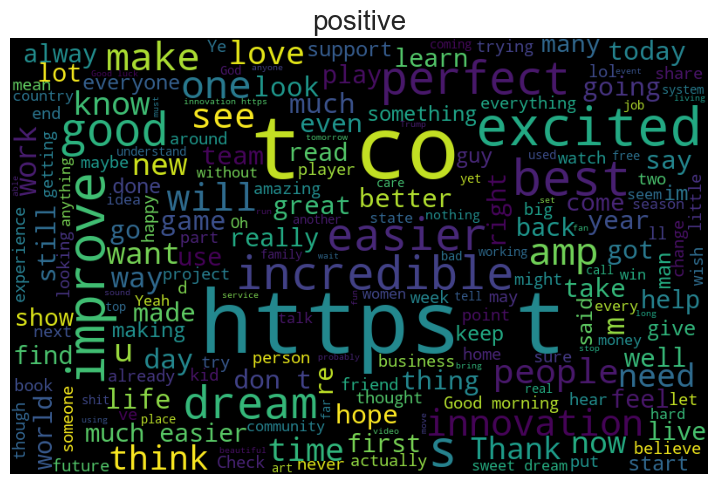

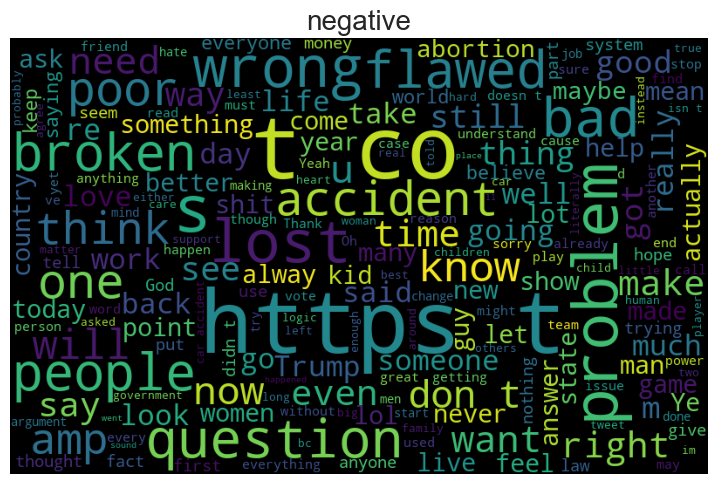

In [24]:
for i in c:
    word_cloud(i)

In [25]:
sw = stopwords.words('english')

In [26]:
lemmatizer = WordNetLemmatizer()

In [27]:
def preprocessing_text(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub(r'http\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [28]:
df_balanced['preprocessed_text'] = df_balanced['Text'].apply(preprocessing_text)

In [29]:
df_balanced.head()

,Text,Language,Label,preprocessed_text
183931,@Lion0fWar @JimBlack48 @tedcruz Anyway; the in...,en,positive,lion fwar jimblack tedcruz anyway individual r...
698185,Incredible face! So Gorgeous like a CG\n\nKARI...,en,positive,incredible face gorgeous like cg karina kwangy...
370923,harmony tan!!! incredible,en,positive,harmony tan incredible
665355,@GaryCarr19 @King_Willi5 @overtime @_kayinlee ...,en,positive,garycarr king willi overtime kayinlee possibly...
69446,This New Kindle Unlimited Deal is Incredible: ...,en,positive,new kindle unlimited deal incredible month fre...


In [30]:
X = df_balanced['preprocessed_text']
y = df_balanced['Label']

In [40]:
le = LabelEncoder()

In [41]:
y_le = le.fit_transform(y)

In [42]:
y_le

array([1, 1, 1, ..., 0, 0, 0])

In [252]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [51]:
vectorizer = TfidfVectorizer(strip_accents = 'ascii', analyzer = 'word', smooth_idf = True, norm = None, min_df = 10)
X_v = vectorizer.fit_transform(df_balanced['preprocessed_text'])

In [54]:
X_v.shape

(300000, 22910)

In [69]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_v, y_le, test_size = 0.2, random_state = 101, stratify = y_le,
                                                            shuffle = True)

In [72]:
scores_n = []
for i in range(1, 11):
    rf_n = RandomForestClassifier(n_estimators = i, criterion = 'entropy', n_jobs = -1)
    rf_n.fit(X_train_n, y_train_n)
    cvs = cross_val_score(rf_n, X_train_n, y_train_n, cv = 5)
    scores_n.append(cvs.mean())

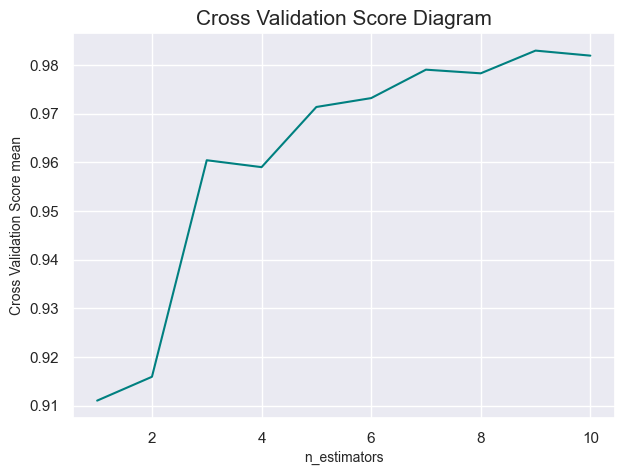

In [73]:
plt.figure(figsize = (7, 5))
plt.plot(range(1, 11), scores_n, color = 'teal')
plt.title('Cross Validation Score Diagram', fontsize = 15)
plt.xlabel('n_estimators', fontsize = 10)
plt.ylabel('Cross Validation Score mean', fontsize = 10)
plt.show()

In [74]:
model_n = RandomForestClassifier(n_estimators = 9, criterion = 'entropy', n_jobs = -1)

In [76]:
model_n.fit(X_train_n, y_train_n)

RandomForestClassifier(criterion='entropy', n_estimators=9, n_jobs=-1)

In [77]:
y_prediction = model_n.predict(X_test_n)

In [78]:
print(classification_report(y_test_n, y_prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30000
           1       0.99      0.98      0.98     30000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



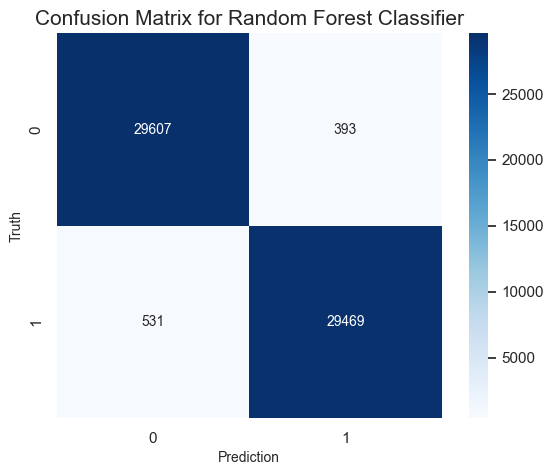

In [79]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test_n, y_prediction), annot = True, square = True, cbar = True, fmt = 'd', annot_kws = {'size': 10},
            cmap = 'Blues')
plt.title('Confusion Matrix for Random Forest Classifier', fontsize = 15)
plt.xlabel('Prediction', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()